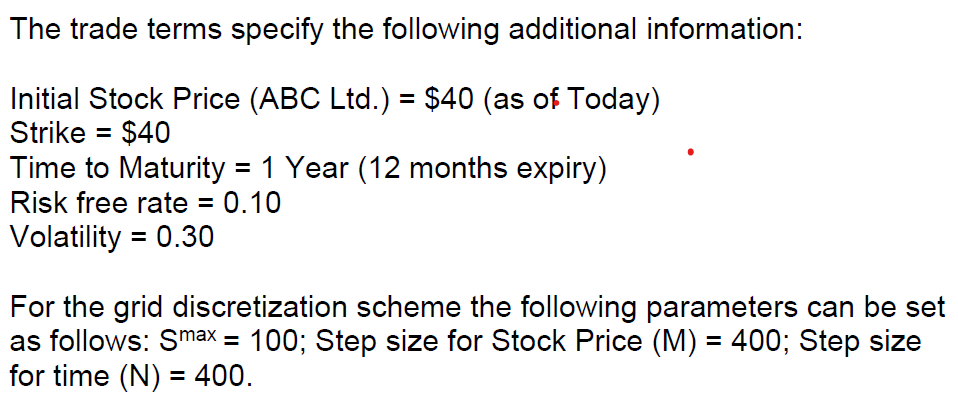

In [1]:
import numpy as np
import scipy.linalg as linalg
from numpy import exp

In [2]:
S0=40; K=40; r=0.1; T=1; sigma=0.3; Smax=100; M=400; N=400; CALLvsPUT='PUT'

In [3]:
dS=Smax/float(M)
dt=T/float(N)
i_values=np.arange(M)
j_values=np.arange(N)
grid=np.zeros(shape=(M+1,N+1))
boundary_conds=np.linspace(0,Smax,M+1)

In [4]:
if CALLvsPUT=='CALL':
    grid[:,-1]= np.maximum(boundary_conds-K,0)
    grid[-1,:-1]= Smax - K*exp(-r*dt*(N-j_values))  
if CALLvsPUT=='PUT':
    grid[:,-1]= np.maximum(K-boundary_conds,0)
    grid[0,:-1]=K*exp(-r*dt*(N-j_values))
    

In [5]:
a= 0.5*dt*((r*i_values) - (sigma**2 * i_values**2))
b= 1 + dt*((sigma**2 * i_values**2) + r)
c= -0.5*dt*((r*i_values) + (sigma**2 * i_values**2))

coeffs= np.diag(a[2:M],-1) + np.diag(b[1:M]) + np.diag(c[1:M-1],1)

In [6]:
P, L, U = linalg.lu(coeffs)
aux = np.zeros(M-1)
for j in reversed(range(N)):
    aux[0] = np.dot(a[1], grid[0, j])
    aux[-1]= np.dot(c[-1],grid[-1,j])
    x1 = linalg.solve(L, grid[1:M, j+1]-aux)
    x2 = linalg.solve(U, x1)
    grid[1:M, j] = x2            

In [7]:
np.interp(S0,boundary_conds,grid[:,0])

2.8856117994891246

Down and Out PUT Option Valuation

In [8]:
def Implicit_DandO(S0, K, T, r, sigma, Sbarrier, Smax, M, N, CALLvsPUT):
    dS=(Smax-Sbarrier)/float(M)
    dt=T/float(N)
    boundary_conds=np.linspace(Sbarrier,Smax,M+1)
    i_values = boundary_conds/dS
    j_values=np.arange(N)
    grid=np.zeros(shape=(M+1,N+1))
    
    if CALLvsPUT=='CALL':
        grid[:, -1]= np.maximum(boundary_conds-K,0)
        grid[-1, :-1]= Smax - K*exp(-r*dt*(N-j_values)) 
        
    if CALLvsPUT=='PUT':
        grid[:, -1] = np.maximum(K-boundary_conds, 0)
        grid[0, :] = 0.0
        
    a= 0.5*dt*((r*i_values) - (sigma**2 * i_values**2))
    b= 1 + dt*((sigma**2 * i_values**2) + r)
    c= -0.5*dt*((r*i_values) + (sigma**2 * i_values**2))

    coeffs= np.diag(a[2:M],-1) + np.diag(b[1:M]) + np.diag(c[1:M-1],1)
    P, L, U = linalg.lu(coeffs)
    aux = np.zeros(M-1)
    for j in reversed(range(N)):
        aux[0] = np.dot(a[1], grid[0, j])
        aux[-1]= np.dot(c[-1],grid[-1,j])
        x1 = linalg.solve(L, grid[1:M, j+1]-aux)
        x2 = linalg.solve(U, x1)
        grid[1:M, j] = x2            
    
    return np.interp(S0,boundary_conds,grid[:,0])

In [9]:
option = Implicit_DandO(40, 40, 1.0, 0.1, 0.3, 30, 100, 400, 400, 'PUT')
print ('down-out put : %0.2f' %option)

down-out put : 0.59


My implementation (wrong as of now)

In [10]:
def ImplicitFDS(S0,K,r,T,sigma,Sbarrier,Smax,M,N,CALLvsPUT):
    dS=Smax/float(M)
    dt=T/float(N)
    i_values=np.arange(M)
    j_values=np.arange(N)
    grid=np.zeros(shape=(M+1,N+1))
    boundary_conds=np.linspace(Sbarrier,Smax,M+1)
    
    if CALLvsPUT=='CALL':
        grid[0,:]=0
        grid[1:,-1]= np.maximum(boundary_conds[1:]-K,0)
        grid[-1,:-1]= Smax - K*exp(-r*dt*(N-j_values))
    if CALLvsPUT=='PUT':
        grid[int(Sbarrier/dS)+1:,-1]= np.maximum(K-boundary_conds[int(Sbarrier/dS)+1],0)
        grid[0,:-1]=0
        
    a= 0.5*dt*((r*i_values) - (sigma**2 * i_values**2))
    b= 1 + dt*((sigma**2 * i_values**2) + r)
    c= -0.5*dt*((r*i_values) + (sigma**2 * i_values**2))
    coeffs= np.diag(a[2:M],-1) + np.diag(b[1:M]) + np.diag(c[1:M-1],1)
    
    P, L, U = linalg.lu(coeffs)
    aux = np.zeros(M-1)
    for j in reversed(range(N)):
        aux[0] = np.dot(-a[1], grid[0, j])
        aux[-1]= np.dot(-c[-1],grid[-1,j])
        x1 = linalg.solve(L, grid[1:M, j+1]+aux)
        x2 = linalg.solve(U, x1)
        grid[1:M, j] = x2  
    
    return np.interp(S0,boundary_conds,grid[:,0])

In [11]:
ImplicitFDS(S0=40,K=40,r=0.10,T=1,sigma=0.30,Sbarrier=30,Smax=100,M=400,N=400,CALLvsPUT='PUT')

0.0

In [12]:
def ImplicitFDS2(S0,K,r,T,sigma,Sbarrier,Smax,M,N,CALLvsPUT):
    dS=(Smax-Sbarrier)/float(M)
    dt=T/float(N)
    i_values=np.arange(M)
    j_values=np.arange(N)
    grid=np.zeros(shape=(M+1,N+1))
    boundary_conds=np.linspace(Sbarrier,Smax,M+1)
    
    if CALLvsPUT=='CALL':
        grid[1:,-1]= np.maximum(boundary_conds[1]-K,0)
        grid[-1,:-1]= Smax - K*exp(-r*dt*(N-j_values))  
    if CALLvsPUT=='PUT':
        grid[int(Sbarrier/dS)+1:,-1]= np.maximum(K-boundary_conds[int(Sbarrier/dS)+1],0)
        grid[0,:-1]=0
        
    a= 0.5*dt*((r*i_values) - (sigma**2 * i_values**2))
    b= 1 + dt*((sigma**2 * i_values**2) + r)
    c= -0.5*dt*((r*i_values) + (sigma**2 * i_values**2))
    coeffs= np.diag(a[2:M],-1) + np.diag(b[1:M]) + np.diag(c[1:M-1],1)
    
    P, L, U = linalg.lu(coeffs)
    aux = np.zeros(M-1)
    for j in reversed(range(N)):
        aux[0] = np.dot(-a[1], grid[0, j])
        aux[-1]= np.dot(-c[-1],grid[-1,j])
        x1 = linalg.solve(L, grid[1:M, j+1]+aux)
        x2 = linalg.solve(U, x1)
        grid[1:M, j] = x2  
    
    return np.interp(S0,boundary_conds,grid[:,0])

In [13]:
ImplicitFDS2(S0=50,K=50,r=0.05,T=1,sigma=0.30,Sbarrier=45,Smax=120,M=400,N=400,CALLvsPUT='CALL')

1.4972161909169885e-16